# Evaluation of solar conjunction

In [3]:
import numpy as np
import numpy.linalg as la
import pykep as pk
from pykep.planet import jpl_lp
from pykep import epoch
import pygmo as pg
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import datetime

%matplotlib notebook

%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append("../")
import pyxplorer as pxp

In [5]:
pk.util.load_spice_kernel(os.path.join(os.environ.get("SPICE"), "spk", "de440.bsp"))
pk.util.load_spice_kernel(os.path.join(os.environ.get("SPICE"), "lsk", "naif0012.tls"))

In [6]:
ssdict = pxp.solar_system_spice()
ssdict["earth"]

Planet Name: 3, SUN, ECLIPJ2000
Own gravity parameter: 398600441800000
Central body gravity parameter: 1.32712440018e+20
Planet radius: 6378000
Planet safe radius: 6696900
Target planet: 3
Observer: SUN
Reference frame: ECLIPJ2000
Aberrations: NONE
Ephemerides type: SPICE Toolbox

In [53]:
t_earliest = pk.epoch_from_string('2040-01-01 00:00:00.000').mjd2000
t_latest = pk.epoch_from_string('2050-01-05 00:00:00.000').mjd2000

In [93]:
mission_epoch = np.linspace(
    t_earliest, t_latest, 10000
)

In [94]:
SUN_EXCLUSION_ANGLE = 10 * np.pi/180

In [95]:
r_earth = np.zeros((3,len(mission_epoch)))
r_saturn = np.zeros((3,len(mission_epoch)))
phis = []
distance_Earth_Saturn = []

visible_epochs = []
nonvisible_epochs = []

for idx,epoch_test in enumerate(mission_epoch):
    rE,_ = ssdict["earth"].eph(epoch_test)
    r_earth[:,idx] = rE
    rS,_ = ssdict["saturn"].eph(epoch_test)
    r_saturn[:,idx] = rS
    
    # vector Earth -> Sun and Earth -> Saturn
    r_E_Sun = -np.array(rE)
    r_E_Sat = np.array(rS) - np.array(rE)
    
    # store distance
    distance_Earth_Saturn.append(la.norm(r_E_Sat))
    
    # check for Sun exclusion angle
#     phi_check = np.arccos(
#         np.dot(rE, rS)/(la.norm(rE)*la.norm(rS))
#         #np.dot(r_E_Sun, r_E_Sat)/(la.norm(r_E_Sun)*la.norm(r_E_Sat))
#     )
    phi_check = np.arccos(
        np.dot(r_E_Sun, r_E_Sat)/(la.norm(r_E_Sun)*la.norm(r_E_Sat))
    )
    phis.append(phi_check)
    
    # phis
    earth_sun_saturn_angle = np.dot(np.array(rE), np.array(rS))/(la.norm(np.array(rE))*la.norm(np.array(rS)))
    
#     if earth_sun_saturn_angle <= np.pi/2:
#         # visible automatically
#         visible_epochs.append(
#             (epoch_test, np.array(rE), np.array(rS))
#         )
#     else:
    # check angle
    #if phi_check < np.pi - SUN_EXCLUSION_ANGLE/2:
    if phi_check > SUN_EXCLUSION_ANGLE:
        # visible
        visible_epochs.append(
            (epoch_test, np.array(rE), np.array(rS))
        )
    else:
        # not visible
        nonvisible_epochs.append(
            (epoch_test, np.array(rE), np.array(rS))
        )

<IPython.core.display.Javascript object>


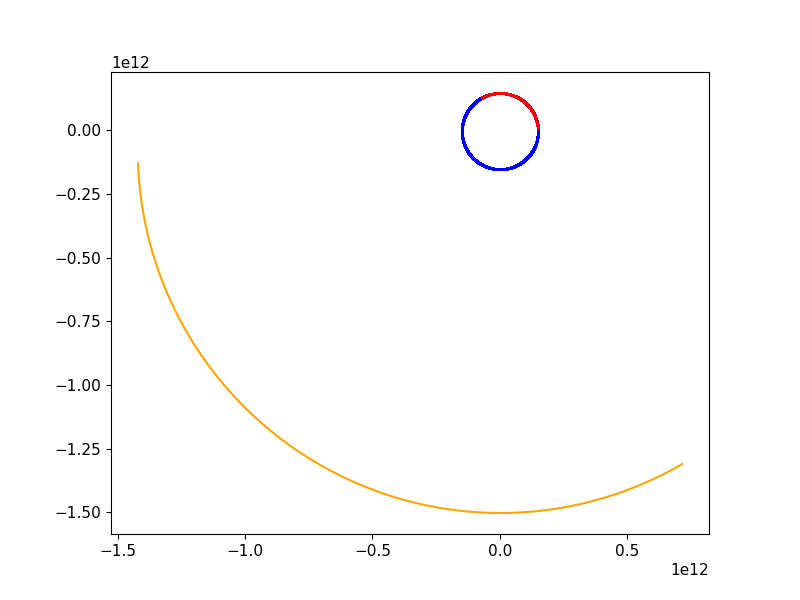

In [96]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
#ax.plot(r_earth[0,:], r_earth[1,:], c="blue")
ax.plot(r_saturn[0,:], r_saturn[1,:], c="orange")

x_plot, y_plot = [], []
for vis in visible_epochs:
    x_plot.append(vis[1][0])
    y_plot.append(vis[1][1])
ax.scatter(x_plot, y_plot, c="blue", marker=".", s=2)
    
x_plot, y_plot = [], []
for vis in nonvisible_epochs:
    x_plot.append(vis[1][0])
    y_plot.append(vis[1][1])
ax.scatter(x_plot, y_plot, c="red", marker=".", s=2)
    
ax.set_aspect('equal')
plt.show()

In [98]:
mission_epoch_matplotlib = [
    np.datetime64(
                datetime.datetime.strptime(
                    pk.epoch(el).__str__()[0:11], 
                    '%Y-%b-%d'
                ).strftime('%Y-%m-%d')
            )
    for el in mission_epoch
]

In [99]:
# fig, axs = plt.subplots(2,1,figsize=(8,6))
# axs[0].plot(mission_epoch_matplotlib, np.array(phis)*180/np.pi, c="blue")
# axs[0].set(xlabel="Arrival Date", ylabel="Sun-Earth-Saturn angle, deg")
# axs[0].hlines(
#     (np.pi - SUN_EXCLUSION_ANGLE/2)*180/np.pi,
#     min(mission_epoch_matplotlib),
#     max(mission_epoch_matplotlib),
#     color='red',
# )

# axs[1].plot(mission_epoch_matplotlib, np.array(distance_Earth_Saturn)/pk.AU, c="blue")
# axs[1].set(xlabel="Arrival Date", ylabel="Earth-Saturn distance, AU")

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()

In [100]:
c_light = 299792458.0  # m/s

<IPython.core.display.Javascript object>


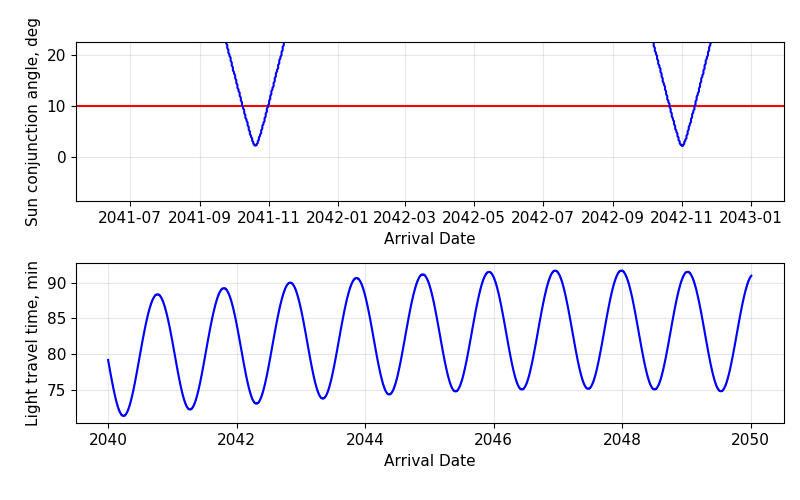

In [101]:
plt.rcParams["font.size"] = 11

fig, axs = plt.subplots(2,1,figsize=(8,5))

axs[0].set(xlabel="Arrival Date", ylabel="Sun conjunction angle, deg")
axs[0].hlines(
    SUN_EXCLUSION_ANGLE*180/np.pi,
    min(mission_epoch_matplotlib),
    max(mission_epoch_matplotlib),
    color='red',
)
axs[0].plot(mission_epoch_matplotlib, np.array(phis)*180/np.pi, c="blue")
axs[0].grid(True, alpha=0.3)

axs[1].plot(mission_epoch_matplotlib, (np.array(distance_Earth_Saturn)/c_light)/60, c="blue")
axs[1].set(xlabel="Arrival Date", ylabel="Light travel time, min")
axs[1].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [103]:
fig.savefig("./plots/sun_conjuncture_2044.png")

In [121]:
dir(duration)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_interface__',
 '__array_priority__',
 '__array_struct__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__le__',
 '__lshift__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rlshift__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__round__',
 '__rpow__',
 '__rrshift__',
 '__rshift__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__xor__',
 'all',
 'any',
 'argmax',
 'argmin',
 'a

In [130]:
start_or_end = 0

for idx, phi in enumerate(phis): 
    if np.abs(phi - SUN_EXCLUSION_ANGLE) < 1e-2:
        if start_or_end == 0:
            start_epoch = mission_epoch_matplotlib[idx]
            start_or_end = 1
        else:
            end_epoch = mission_epoch_matplotlib[idx]
            duration = end_epoch - start_epoch
            if 10 < duration < 2000:
                print(f"{start_epoch} ~ {end_epoch}, lasts {duration}")
                start_or_end = 0

2040-09-25 ~ 2040-10-18, lasts 23 days
2040-10-18 ~ 2041-10-08, lasts 355 days
2041-10-08 ~ 2041-10-30, lasts 22 days
2041-10-31 ~ 2042-10-21, lasts 355 days
2042-10-21 ~ 2042-11-12, lasts 22 days
2042-11-12 ~ 2043-11-02, lasts 355 days
2043-11-02 ~ 2043-11-24, lasts 22 days
2043-11-24 ~ 2044-11-12, lasts 354 days
2044-11-13 ~ 2044-12-05, lasts 22 days
2044-12-05 ~ 2045-11-24, lasts 354 days
2045-11-24 ~ 2045-12-16, lasts 22 days
2045-12-16 ~ 2046-12-05, lasts 354 days
2046-12-06 ~ 2046-12-28, lasts 22 days
2046-12-28 ~ 2047-12-17, lasts 354 days
2047-12-17 ~ 2048-01-08, lasts 22 days
2048-01-08 ~ 2048-12-27, lasts 354 days
2048-12-27 ~ 2049-01-18, lasts 22 days


```
Communication blackout:
2043.11.01 - 2043.11.24
2044.11.11 - 2044.12.05
2045.11.24 - 2045.12.16
```

In [17]:
160/30.5

5.245901639344262